In [2]:
from typing import TypedDict
from langgraph.graph import StateGraph,START,END


In [3]:
class BatsmanState(TypedDict):
    runs: int
    balls: int
    fours: int
    sixes: int

    sr: float
    bpb: float
    boundary_percent: float
    summary: str
    

In [12]:
def calculate_strikeRate(state:BatsmanState):
    runs=state['runs']
    balls=state['balls']

    sr=(runs/balls)*100
    return {'sr':sr}

def calculate_bpb(state:BatsmanState):
    bpb=state['balls']/(state['fours']+state['sixes'])
    return {'bpb':bpb}

def calculate_boundryPer(state:BatsmanState):
    bp=((state['fours']*4+state['sixes']*6)/state['runs'])*100
    return {'boundary_percent':bp}

def summary(state:BatsmanState):
    summary = f"""
    Strike Rate - {state['sr']} \n
    Balls per boundary - {state['bpb']} \n
    Boundary percent - {state['boundary_percent']}
    """
    
    return {'summary': summary}

In [13]:
graph=StateGraph(BatsmanState)

graph.add_node('calculate_strikeRate',calculate_strikeRate)
graph.add_node('calculate_bpb',calculate_bpb)
graph.add_node('calculate_boundryPer',calculate_boundryPer)
graph.add_node('summary',summary)

graph.add_edge(START,'calculate_strikeRate')
graph.add_edge(START,'calculate_bpb')
graph.add_edge(START,'calculate_boundryPer')

graph.add_edge('calculate_strikeRate','summary')
graph.add_edge('calculate_bpb','summary')
graph.add_edge('calculate_boundryPer','summary')

graph.add_edge('summary',END)
workflow=graph.compile()

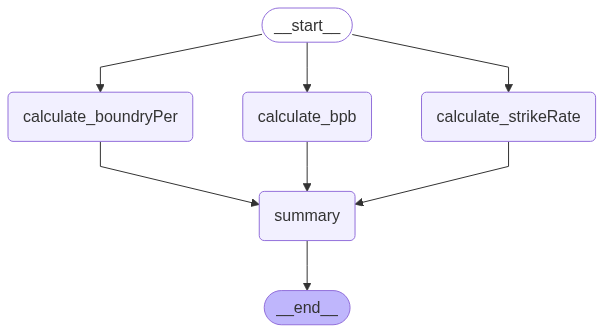

In [14]:
workflow

In [15]:
intial_state = {
    'runs': 100,
    'balls': 50,
    'fours': 6,
    'sixes': 4
}

output=workflow.invoke(intial_state)
print(output)

{'runs': 100, 'balls': 50, 'fours': 6, 'sixes': 4, 'sr': 200.0, 'bpb': 5.0, 'boundary_percent': 48.0, 'summary': '\n    Strike Rate - 200.0 \n\n    Balls per boundary - 5.0 \n\n    Boundary percent - 48.0\n    '}


## Adding LLM

### 1.Example 1

In [14]:
import os
from dotenv import load_dotenv
load_dotenv()
groq_api=os.getenv('groq_api')
from langchain_groq import ChatGroq
from pydantic import BaseModel,Field
from typing import Annotated,TypedDict
from langgraph.graph import StateGraph,START,END
import operator


In [5]:
llm=ChatGroq(model='gemma2-9b-it',api_key=groq_api)


In [11]:
class UpscPractice(TypedDict):
    essay:str
    analysis_feedback:str
    language_feedback:str
    clarity_feedback:str
    overall_feedback:str
    individual_scores: Annotated[list[int], operator.add]
    avg_score:float

In [8]:
class Evaluation(BaseModel):
    feedback:str=Field(description='Detailed Feedback of easy')
    score:int=Field('Score out of 10',le=10,ge=0)

In [10]:
structured_model=llm.with_structured_output(Evaluation)

In [47]:
def analysis_feedback(state:UpscPractice):
    prompt = f'Evaluate the depth of analysis of the following essay and provide a feedback and assign a score out of 10 \n {state["essay"]}'
    output = structured_model.invoke(prompt)
    return {'analysis_feedback':output.feedback,'individual_scores':[output.score]}

def language_feedback(state:UpscPractice):
    prompt = f'Evaluate the depth of langauge of the following essay and provide a feedback and assign a score out of 10 \n {state["essay"]}'
    output = structured_model.invoke(prompt)
    return {'language_feedback':output.feedback,'individual_scores':[output.score]}

def clarity_feedback(state:UpscPractice):
    prompt = f'Evaluate the thought of the clearity of the following essay and provide a feedback and assign a score out of 10 \n {state["essay"]}'
    output = structured_model.invoke(prompt)
    return {'clarity_feedback':output.feedback,'individual_scores':[output.score]}

def overall_feedback(state:UpscPractice):
    prompt = f'Based on the following feedbacks create a summarized feedback \n language feedback - {state["language_feedback"]} \n depth of analysis feedback - {state["analysis_feedback"]} \n clarity of thought feedback - {state["clarity_feedback"]}'
    output = llm.invoke(prompt).content
    avg_score = sum(state['individual_scores'])/len(state['individual_scores'])
    return {'overall_feedback':output,'avg_score':[avg_score]}


In [48]:
graph=StateGraph(UpscPractice)

graph.add_node('analysis_feedback',analysis_feedback)
graph.add_node('language_feedback',language_feedback)
graph.add_node('clarity_feedback',clarity_feedback)
graph.add_node('overall_feedback',overall_feedback)

graph.add_edge(START,'analysis_feedback')
graph.add_edge(START,'language_feedback')
graph.add_edge(START,'clarity_feedback')
graph.add_edge('analysis_feedback','overall_feedback')
graph.add_edge('language_feedback','overall_feedback')
graph.add_edge('clarity_feedback','overall_feedback')

graph.add_edge('overall_feedback',END)

workflow=graph.compile()


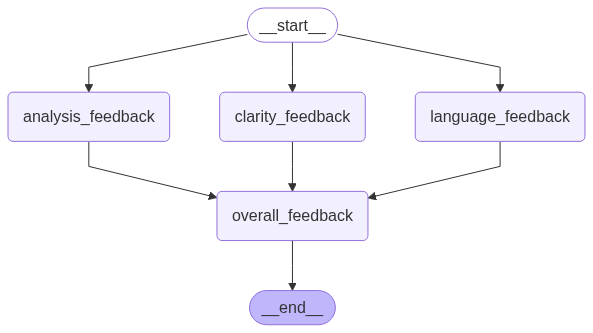

In [49]:
workflow

In [50]:
essay1 = """India and AI Time

Now world change very fast because new tech call Artificial Intel… something (AI). India also want become big in this AI thing. If work hard, India can go top. But if no careful, India go back.

India have many good. We have smart student, many engine-ear, and good IT peoples. Big company like TCS, Infosys, Wipro already use AI. Government also do program “AI for All”. It want AI in farm, doctor place, school and transport.

In farm, AI help farmer know when to put seed, when rain come, how stop bug. In health, AI help doctor see sick early. In school, AI help student learn good. Government office use AI to find bad people and work fast.

But problem come also. First is many villager no have phone or internet. So AI not help them. Second, many people lose job because AI and machine do work. Poor people get more bad.

One more big problem is privacy. AI need big big data. Who take care? India still make data rule. If no strong rule, AI do bad.

India must all people together – govern, school, company and normal people. We teach AI and make sure AI not bad. Also talk to other country and learn from them.

If India use AI good way, we become strong, help poor and make better life. But if only rich use AI, and poor no get, then big bad thing happen.

So, in short, AI time in India have many hope and many danger. We must go right road. AI must help all people, not only some. Then India grow big and world say "good job India"."""


In [51]:
intial_state={'essay':essay1}
result=workflow.invoke(intial_state)

In [52]:
result

{'essay': 'India and AI Time\n\nNow world change very fast because new tech call Artificial Intel… something (AI). India also want become big in this AI thing. If work hard, India can go top. But if no careful, India go back.\n\nIndia have many good. We have smart student, many engine-ear, and good IT peoples. Big company like TCS, Infosys, Wipro already use AI. Government also do program “AI for All”. It want AI in farm, doctor place, school and transport.\n\nIn farm, AI help farmer know when to put seed, when rain come, how stop bug. In health, AI help doctor see sick early. In school, AI help student learn good. Government office use AI to find bad people and work fast.\n\nBut problem come also. First is many villager no have phone or internet. So AI not help them. Second, many people lose job because AI and machine do work. Poor people get more bad.\n\nOne more big problem is privacy. AI need big big data. Who take care? India still make data rule. If no strong rule, AI do bad.\n\n